In [1]:

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
 # Define the relative path to the data file
file_path = "data/preprocessed_aqi_data.csv"
df=pd.read_csv(file_path)
#Change column name
df.rename(columns={"timestamp":"DateTime","pm25":"pm2_5","no2":"nitrogen_dioxide","o3":"ozone"
                   ,"so2":"sulphor_dioxide","co":"carbon_monooxide"},inplace=True)
df.tail(3)



,DateTime,aqi,pm2_5,pm10,nitrogen_dioxide,ozone,sulphor_dioxide,carbon_monooxide,temp_c,humidity,wind_speed_kph,precipitation_mm
4312,2026-01-24 16:00:00,3,19.81,70.09,1.83,116.35,5.39,191.45,15.2,43,14.5,0.0
4313,2026-01-24 17:00:00,3,21.46,76.50,1.96,113.97,5.56,203.16,14.6,43,15.0,0.0
4314,2026-01-24 18:00:00,3,23.17,82.34,1.97,112.33,5.52,215.20,14.2,44,15.7,0.0


In [2]:
df_final=df.copy()

Feature Engineering

C:\Users\ayesh\AppData\Local\Temp\ipykernel_23840\3546737865.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_by_day, x="day_of_week", y="aqi", palette="viridis", errorbar=None)


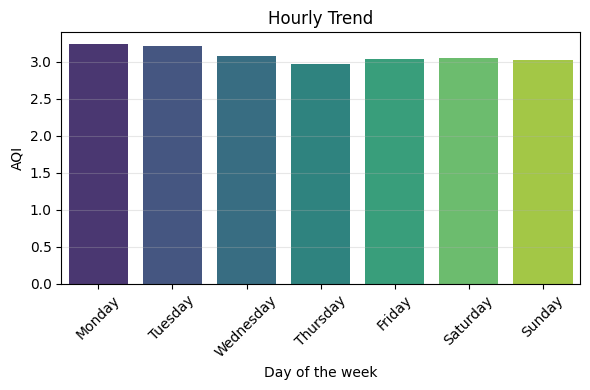

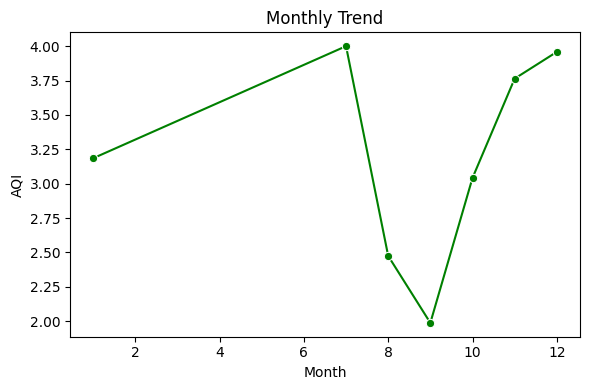

In [3]:

df_final["DateTime"] = pd.to_datetime(df_final["DateTime"])
# Time Based Feature Extraction temporal
df_final["year"]=df_final["DateTime"].dt.year
df_final["month"]=df_final["DateTime"].dt.month
df_final["day"]=df_final["DateTime"].dt.day
df_final["hour"]=df_final["DateTime"].dt.hour
df_final["minute"]=df_final["DateTime"].dt.minute
df_final["day_of_week"] = df_final["DateTime"].dt.day_name()

# Define the correct order
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# Convert day_of_week to a categorical type with the order
df_final["day_of_week"] = pd.Categorical(df_final["day_of_week"], categories=day_order, ordered=True)

# Group for hourly average
avg_by_day = df_final.groupby("day_of_week", observed=True)["aqi"].mean().reset_index()


plt.figure(figsize=(6,4))
sns.barplot(data=avg_by_day, x="day_of_week", y="aqi", palette="viridis", errorbar=None)
plt.xlabel("Day of the week")
plt.ylabel("AQI")
plt.title("Hourly Trend")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.lineplot(data=df_final, x="month", y="aqi", marker='o', errorbar=None, color="green")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.title("Monthly Trend")
plt.tight_layout()
plt.show()

# # ================= CREATE df_final =================


# ================= DERIVED FEATURES =================
#

In [ ]:
df_final=df.copy()

In [4]:
#Derived Features
df_final["aqi_change"]=df_final["aqi"].diff()
df_final["aqi_pct_change"]=df_final["aqi"].pct_change()
df_final["temp_humid_interaction"]=df_final["temp_c"]*df_final["humidity"]
df_final["wind_pollution_interaction"]=df_final["wind_speed_kph"]*df_final["pm2_5"]

#Lag And rolling Feature
df_final["aqi_lag_1"]=df_final["aqi"].shift(1)
df_final["aqi_lag_3"]=df_final["aqi"].shift(3)
df_final["aqi_roll_12h"] = df_final["aqi"].rolling(window=12).mean()
df_final["aqi_roll_max_24h"] = df_final["aqi"].rolling(window=24).max()
# Target: 24-hour ahead AQI
df_final["target_aqi_24h"] = df_final["aqi"].shift(-24)

#pollutant list
# Pollutant rolling statistics
pollutants = ["pm2_5","pm10","nitrogen_dioxide","carbon_monooxide","ozone","sulphor_dioxide"]
for col in pollutants:
    df_final[f"{col}_rolling_mean_24h"] = df_final[col].rolling(window=24).mean()
    df_final[f"{col}_rolling_max_24h"] = df_final[col].rolling(window=24).max()



In [59]:
df_final.columns

Index(['DateTime', 'aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone',
       'sulphor_dioxide', 'carbon_monooxide', 'temp_c', 'humidity',
       'wind_speed_kph', 'precipitation_mm', 'year', 'month', 'day', 'hour',
       'minute', 'day_of_week', 'aqi_change', 'aqi_pct_change',
       'temp_humid_interaction', 'wind_pollution_interaction', 'aqi_lag_1',
       'aqi_lag_3', 'aqi_roll_12h', 'aqi_roll_max_24h', 'target_aqi_24h',
       'pm2_5_rolling_mean_24h', 'pm2_5_rolling_max_24h',
       'pm10_rolling_mean_24h', 'pm10_rolling_max_24h',
       'nitrogen_dioxide_rolling_mean_24h', 'nitrogen_dioxide_rolling_max_24h',
       'carbon_monooxide_rolling_mean_24h', 'carbon_monooxide_rolling_max_24h',
       'ozone_rolling_mean_24h', 'ozone_rolling_max_24h',
       'sulphor_dioxide_rolling_mean_24h', 'sulphor_dioxide_rolling_max_24h'],
      dtype='object')

In [5]:
#Drops Nans Created By Rolling and lag features
df_final=df_final.dropna().reset_index(drop=True)
print(df_final.shape)
# print(df.shape)
# df.isnull().sum()
# df_final.isna().sum().sum()

(4268, 39)


Correlation Bar PLot

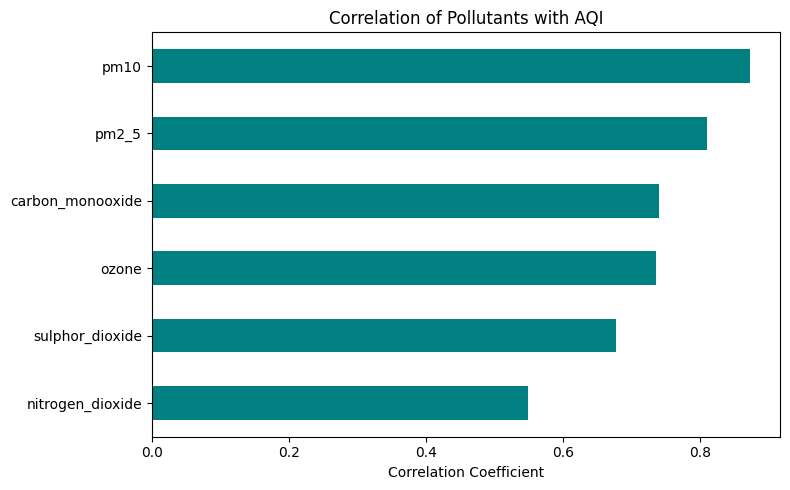

In [6]:
pollutants=pollutants=["pm2_5","pm10","nitrogen_dioxide","carbon_monooxide","ozone","sulphor_dioxide"]
corr_df=df_final[["aqi"]+pollutants].dropna()
corr_values = corr_df.corr()["aqi"].drop("aqi").sort_values()
#Correlation BarPlot
plt.figure(figsize=(8, 5))
corr_values.plot(kind="barh",color="teal")
plt.title("Correlation of Pollutants with AQI")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

In [61]:
df_final.columns

Index(['DateTime', 'aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone',
       'sulphor_dioxide', 'carbon_monooxide', 'temp_c', 'humidity',
       'wind_speed_kph', 'precipitation_mm', 'year', 'month', 'day', 'hour',
       'minute', 'day_of_week', 'aqi_change', 'aqi_pct_change',
       'temp_humid_interaction', 'wind_pollution_interaction', 'aqi_lag_1',
       'aqi_lag_3', 'aqi_roll_12h', 'aqi_roll_max_24h', 'target_aqi_24h',
       'pm2_5_rolling_mean_24h', 'pm2_5_rolling_max_24h',
       'pm10_rolling_mean_24h', 'pm10_rolling_max_24h',
       'nitrogen_dioxide_rolling_mean_24h', 'nitrogen_dioxide_rolling_max_24h',
       'carbon_monooxide_rolling_mean_24h', 'carbon_monooxide_rolling_max_24h',
       'ozone_rolling_mean_24h', 'ozone_rolling_max_24h',
       'sulphor_dioxide_rolling_mean_24h', 'sulphor_dioxide_rolling_max_24h'],
      dtype='object')

In [7]:
drops_cols = [
    'aqi_roll_12h',
    'minute',
    'aqi_lag_3',
    'pm2_5_rolling_mean_24h',
    'pm10_rolling_mean_24h',
    'nitrogen_dioxide_rolling_mean_24h',
    'carbon_monooxide_rolling_mean_24h',
    'ozone_rolling_mean_24h',
    'sulphor_dioxide_rolling_mean_24h',
    'pm2_5_rolling_max_24h',
    'pm10_rolling_max_24h',
    'nitrogen_dioxide_rolling_max_24h',
    'carbon_monooxide_rolling_max_24h',
    'ozone_rolling_max_24h',
    'sulphor_dioxide_rolling_max_24h',
]

df_final= df_final.drop(columns=drops_cols)
df_final.columns


Index(['DateTime', 'aqi', 'pm2_5', 'pm10', 'nitrogen_dioxide', 'ozone',
       'sulphor_dioxide', 'carbon_monooxide', 'temp_c', 'humidity',
       'wind_speed_kph', 'precipitation_mm', 'year', 'month', 'day', 'hour',
       'day_of_week', 'aqi_change', 'aqi_pct_change', 'temp_humid_interaction',
       'wind_pollution_interaction', 'aqi_lag_1', 'aqi_roll_max_24h',
       'target_aqi_24h'],
      dtype='object')

In [8]:
# Only drop rows if datetime or aqi missing
df_final_clean = df_final.dropna(subset=["DateTime", "aqi"]).reset_index(drop=True)

# Save CSV
df_final_clean.to_csv("data/karachi_aqi_features.csv", index=False)
print(f"✅ Saved {len(df_final_clean)} rows")


✅ Saved 4268 rows
